In [100]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans 

In [101]:
# 1. Load dataset
df = pd.read_csv("customer_cleaned.csv")

for c in ['sale_date', 'last_purchase_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          8000 non-null   int64         
 1   sale_id             8000 non-null   object        
 2   customer_id         8000 non-null   object        
 3   product_id          8000 non-null   object        
 4   product_name        8000 non-null   object        
 5   category            8000 non-null   object        
 6   price               8000 non-null   int64         
 7   quantity            8000 non-null   int64         
 8   sale_date           8000 non-null   datetime64[ns]
 9   total_value         8000 non-null   int64         
 10  age                 8000 non-null   int64         
 11  gender              8000 non-null   object        
 12  region              8000 non-null   object        
 13  segment             8000 non-null   object      

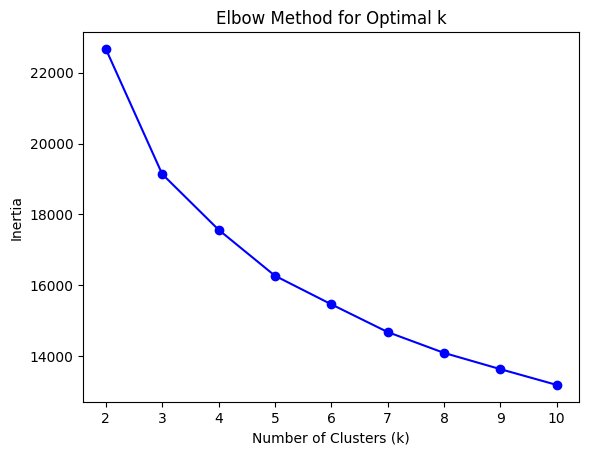

In [122]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

# 2. Feature Engineering
customer_summary = df.groupby("customer_id").agg({
    "sale_id": "count",  # purchase frequency
    "total_value": "sum",  # total spend
    "price": "mean",  # avg spend per product
    "product_id": pd.Series.nunique,  # unique products bought
    "category": pd.Series.nunique,  # number of categories bought
    "last_purchase_date": "max",  # last purchase date
    "age": "last",
    "gender": "last",
    "region": "last",
    "segment": "first",
    "tenure_months": "last",
    "churn": "first"
}).reset_index()

customer_summary.rename(columns={
    "sale_id": "purchase_frequency",
    "total_value": "total_spend",
    "price": "avg_spend",
    "product_id": "unique_products",
    "category": "unique_categories"
}, inplace=True)

# Add num_purchases safely
customer_summary["num_purchases"] = customer_summary["purchase_frequency"]

# Average quantity per customer
avg_quantity = df.groupby("customer_id")["quantity"].mean()
customer_summary = customer_summary.merge(avg_quantity, on="customer_id", how="left")
customer_summary.rename(columns={"quantity": "avg_quantity"}, inplace=True)

# Convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])
last_date = df['sale_date'].max()

# Recency in days
recency = df.groupby("customer_id")["sale_date"].max().apply(lambda x: (last_date - x).days)
customer_summary["recency_days"] = recency.values

# Spend per month (avoid div by zero)
customer_summary["spend_per_month"] = customer_summary["total_spend"] / customer_summary["tenure_months"].replace(0, 1)

# Spend per visit (avoid div by zero)
customer_summary["spend_per_visit"] = customer_summary["total_spend"] / customer_summary["purchase_frequency"].replace(0, 1)

# Frequency (int)
customer_summary["frequency"] = customer_summary["num_purchases"].astype(int)

# Average purchase value (avoid inf)
customer_summary['average_purchase_value'] = (
    customer_summary["total_spend"] / customer_summary["num_purchases"].replace(0, 1)
)

# Days since first purchase
first_purchase = df.groupby("customer_id")["sale_date"].min()
customer_summary["days_since_first_purchase"] = (last_date - first_purchase).dt.days.values

# Monetary per month (avoid div by zero)
customer_summary["monetary_per_month"] = customer_summary["total_spend"] / (customer_summary["tenure_months"].replace(0, 1))

# --- Handle NaN/Inf globally ---
customer_summary = customer_summary.replace([np.inf, -np.inf], np.nan)
customer_summary = customer_summary.fillna(0)

# -------------------
# Features for clustering
# -------------------
numeric_features = [
    "frequency", "total_spend", "avg_spend",
    "unique_products", "unique_categories", "recency_days",
    "age", "tenure_months", "num_purchases",
    "spend_per_visit", "average_purchase_value",
    "days_since_first_purchase", "monetary_per_month"
]

categorical_features = ["gender", "region"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Preprocess features
X = preprocessor.fit_transform(customer_summary)

# -------------------
# Elbow Method
# -------------------
inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()



In [116]:

# Run clustering with chosen K
kmeans = KMeans(n_clusters=2, random_state=42)
customer_summary["cluster"] = kmeans.fit_predict(X)


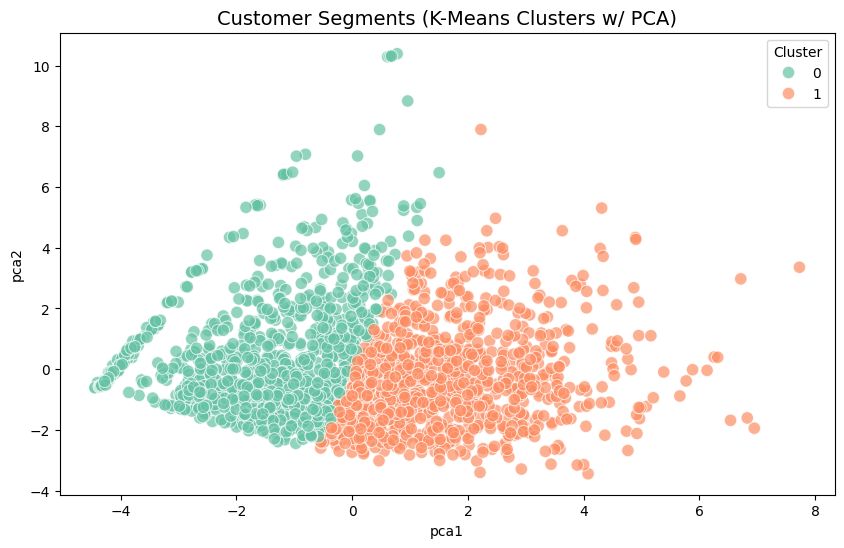

In [114]:
from sklearn.decomposition import PCA

# Run KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
customer_summary["cluster"] = kmeans.fit_predict(X)

# Reduce dimensions to 2D with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add PCA results back to DataFrame for plotting
customer_summary["pca1"] = X_pca[:, 0]
customer_summary["pca2"] = X_pca[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="cluster",
    palette="Set2",
    data=customer_summary,
    alpha=0.7,
    s=80
)
plt.title("Customer Segments (K-Means Clusters w/ PCA)", fontsize=14)
plt.legend(title="Cluster")
plt.show()

In [115]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
sil_score = silhouette_score(X, customer_summary["cluster"])
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.175


In [ ]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Use engineered dataset (customer_summary) instead of raw df
numeric_features = ["frequency", "total_spend", "avg_spend",
                    "unique_products", "unique_categories", "recency_days",
                    "age", "tenure_months", "num_purchases", 
                    "spend_per_visit","average_purchase_value",
                    "days_since_first_purchase", "monetary_per_month"]

categorical_features = ["gender", "region"]

# Preprocess
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(), categorical_features)
])

X = preprocessor.fit_transform(customer_summary)

# Convert back to DataFrame with feature names
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
X_df = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X, columns=feature_names)

# ---------- 1. Variance Ranking ----------
feature_variances = X_df.var().sort_values(ascending=False)

# ---------- 2. Correlation (high = redundant) ----------
corr_matrix = X_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.85)]

# ---------- 3. Silhouette Score Feature Importance ----------
silhouette_scores = {}
for col in X_df.columns:
    km = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = km.fit_predict(X_df[[col]])
    score = silhouette_score(X_df[[col]], labels)
    silhouette_scores[col] = score

silhouette_scores = pd.Series(silhouette_scores).sort_values(ascending=False)

# ---------- Results ----------
print("Features ranked by variance (higher is better):\n", feature_variances)
print("\n Highly correlated features (redundant):", high_corr)
print("\n Features ranked by silhouette score (higher = more useful for clustering):\n", silhouette_scores)


Features ranked by variance (higher is better):
 unique_categories            1.000509
avg_spend                    1.000509
total_spend                  1.000509
frequency                    1.000509
age                          1.000509
num_purchases                1.000509
tenure_months                1.000509
spend_per_visit              1.000509
average_purchase_value       1.000509
monetary_per_month           1.000509
days_since_first_purchase    1.000509
unique_products              1.000509
recency_days                 1.000509
gender_Female                0.250073
gender_Male                  0.250073
region_East                  0.195052
region_South                 0.189175
region_West                  0.186382
region_North                 0.179260
dtype: float64

 Highly correlated features (redundant): ['unique_products', 'num_purchases', 'spend_per_visit', 'average_purchase_value', 'gender_Male']

 Features ranked by silhouette score (higher = more useful for clustering)

In [106]:
with open("../models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_model,f)

NameError: name 'kmeans_model' is not defined

In [123]:
customer_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id                1967 non-null   object        
 1   purchase_frequency         1967 non-null   int64         
 2   total_spend                1967 non-null   int64         
 3   avg_spend                  1967 non-null   float64       
 4   unique_products            1967 non-null   int64         
 5   unique_categories          1967 non-null   int64         
 6   last_purchase_date         1967 non-null   datetime64[ns]
 7   age                        1967 non-null   int64         
 8   gender                     1967 non-null   object        
 9   region                     1967 non-null   object        
 10  segment                    1967 non-null   object        
 11  tenure_months              1967 non-null   int64         
 12  churn 

In [124]:
# Export customer_summary to CSV
customer_summary.to_csv("customer_kmeans.csv", index=False)

